In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import math
import re
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torcheval.metrics.text import Perplexity

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class TimeMachine(Dataset):
    def __init__(self, path, num_steps, train, num_train=10000, num_test=5000):
        super(TimeMachine, self).__init__()

        corpus, self.vocab = self.build(path)

        array = torch.tensor([corpus[i:i+num_steps+1] for i in range(len(corpus)-num_steps)])
        data, target = array[:, :-1], array[:, 1:]

        if train:
            self.data = data[:num_train]
            self.target = target[:num_train]
        else:
            self.data = data[num_train:num_train+num_test]
            self.target = target[num_train:num_train+num_test]

    def __getitem__(self, index):
        return self.data[index], self.target[index]

    def __len__(self):
        return len(self.data)

    def _get_text(self, path):
        with open(path, 'r') as f:
            text = f.read()
        return text

    def _preprocess(self, raw_text):
        return re.sub('[^A-Za-z]+', ' ', raw_text).lower()[1:]

    def _tokenize(self, text):
        return list(text)

    def _build_vocab(self, text):
        vocab = build_vocab_from_iterator(text, specials=["<unk>"])
        vocab.set_default_index(vocab["<unk>"])
        return vocab

    def build(self, path):
        raw_text = self._get_text(path)
        text = self._preprocess(raw_text)
        tokenized = self._tokenize(text)
        vocab = self._build_vocab(tokenized)
        corpus = [vocab[c] for c in tokenized]
        return corpus, vocab

In [6]:
class LM(nn.Module):
    def __init__(self, rnn, vocab_size, num_hiddens):
        super(LM, self).__init__()
        self.vocab_size = vocab_size
        self.rnn = rnn
        self.fc = nn.Linear(num_hiddens, self.vocab_size)

    def forward(self, inputs):
        embs = F.one_hot(inputs, self.vocab_size).type(torch.float32)
        hiddens, _ = self.rnn(embs)
        outputs = torch.transpose(self.fc(hiddens), 0, 1)
        return outputs

    @torch.no_grad()
    def predict(self, text, num_preds, vocab):
        tokenized = list(re.sub('[^A-Za-z]+', ' ', text).lower())
        corpus = torch.tensor([vocab[c] for c in tokenized]).to(DEVICE)

        embs = F.one_hot(corpus, self.vocab_size).type(torch.float32)
        _, hidden = self.rnn(embs)

        outputs = []
        for i in range(num_preds):
            if type(hidden) is tuple:
                output = self.fc(hidden[0])
            elif hidden.size()[0] == 2:
                output = self.fc(hidden[1])
            else:
                output = self.fc(hidden)

            output = F.one_hot(output.argmax(), self.vocab_size).type(torch.float32).unsqueeze(0)
            outputs.append(output)
            _, hidden = self.rnn(output, hidden)

        outputs = torch.cat(outputs, dim=0)
        answer = outputs.argmax(dim=1).tolist()
        answer = vocab.lookup_tokens(answer)
        answer = ''.join(answer)

        return text + answer

In [8]:
PATH = '/content/drive/MyDrive/d2l.ai_implementation/datasets/thetimemachine.txt'
BATCH_SIZE = 1024
NUM_HIDDENS = 32
NUM_STEPS = 32

In [9]:
train_data = TimeMachine(PATH, NUM_STEPS, train=True)
test_data = TimeMachine(PATH, NUM_STEPS, train=False)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [11]:
def train_run_epoch(model, device, train_loader, optimizer, criterion, metric):
    model.train()
    total_loss = 0
    total_ppl = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).t(), target.to(device)

        output = model(data)

        metric.update(output, target)

        output = output.reshape(-1, output.size()[2])
        target = target.flatten()
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_ppl += metric.compute().item()

    avg_loss = total_loss / len(train_loader)
    avg_ppl = total_ppl / len(train_loader)

    return avg_loss, avg_ppl

In [12]:
def test_run_epoch(model, device, test_loader, criterion, metric):
    model.eval()
    total_loss = 0
    total_ppl = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device).t(), target.to(device)

            output = model(data)

            metric.update(output, target)

            output = output.reshape(-1, output.size()[2])
            target = target.flatten()
            loss = criterion(output, target)

            total_loss += loss.item()
            total_ppl += metric.compute().item()

        avg_loss = total_loss / len(test_loader)
        avg_ppl = total_ppl / len(test_loader)

    return avg_loss, avg_ppl

In [13]:
def train(model, device, train_loder, test_loader, optimizer, criterion, metric, num_epochs):
    train_losses = []
    train_ppls = []
    test_losses = []
    test_ppls = []

    for epoch in range(1, num_epochs+1):

        train_loss, train_ppl = train_run_epoch(model, device, train_loader, optimizer, criterion, metric)
        train_losses.append(train_loss)
        train_ppls.append(train_ppl)

        test_loss, test_ppl = test_run_epoch(model, device, test_loader, criterion, metric)
        test_losses.append(test_loss)
        test_ppls.append(test_ppl)

        if epoch % 25 == 0:
            print(f"Epoch [{epoch}/{num_epochs}]")
            print(f"Train Loss = {train_loss:.20f}")
            print(f"Train Perplexity = {train_ppl:.20f}")
            print()
            print(f"Test Loss = {test_loss:.20f}")
            print(f"Test Perplexity = {test_ppl:.20f}")
            print()

    return train_losses, train_ppls, test_losses, test_ppls

In [14]:
LSTM = nn.LSTM(len(train_data.vocab), NUM_HIDDENS)
GRU = nn.GRU(len(train_data.vocab), NUM_HIDDENS)
deepGRU = nn.GRU(len(train_data.vocab), NUM_HIDDENS, num_layers=2)

In [15]:
EPOCHS = 200
criterion = nn.CrossEntropyLoss()
metric = Perplexity().to(DEVICE)

rnns = [('LSTM', LSTM, 4), ('GRU', GRU, 4), ('deepGRU', deepGRU, 2)]

In [16]:
models = dict()

for name, rnn, lr in rnns:
    lm = LM(rnn, len(train_data.vocab), NUM_HIDDENS).to(DEVICE)
    optimizer = optim.SGD(lm.parameters(), lr=lr)

    print(f"Training {name}... \n")
    train_losses, train_ppls, test_losses, test_ppls = train(lm, DEVICE, train_loader, test_loader, optimizer, criterion, metric, EPOCHS)
    d = {
        'model': lm,
        'train_losses': train_losses,
        'train_ppls': train_ppls,
        'test_losses': test_losses,
        'test_ppls': test_ppls
    }
    models[name] = d

Training LSTM... 

Epoch [25/200]
Train Loss = 2.07478871345520010649
Train Perplexity = 10.81384148114340248981

Test Loss = 2.16470446586608877837
Test Perplexity = 10.75844535077636976439

Epoch [50/200]
Train Loss = 1.78150396347045902878
Train Perplexity = 8.68001697121152560044

Test Loss = 1.94870288372039790481
Test Perplexity = 8.65369415083897841612

Epoch [75/200]
Train Loss = 1.61893609762191781343
Train Perplexity = 7.61231674571563310394

Test Loss = 1.92633819580078125000
Test Perplexity = 7.59784070999872263030

Epoch [100/200]
Train Loss = 1.51309583187103280366
Train Perplexity = 6.96560139829816016288

Test Loss = 1.89774849414825430571
Test Perplexity = 6.95646529371831157107

Epoch [125/200]
Train Loss = 1.43956211805343636811
Train Perplexity = 6.52346451756713729964

Test Loss = 1.88996193408966073335
Test Perplexity = 6.51703450426900143810

Epoch [150/200]
Train Loss = 1.37535965442657470703
Train Perplexity = 6.20314856793656499434

Test Loss = 1.9211050033569

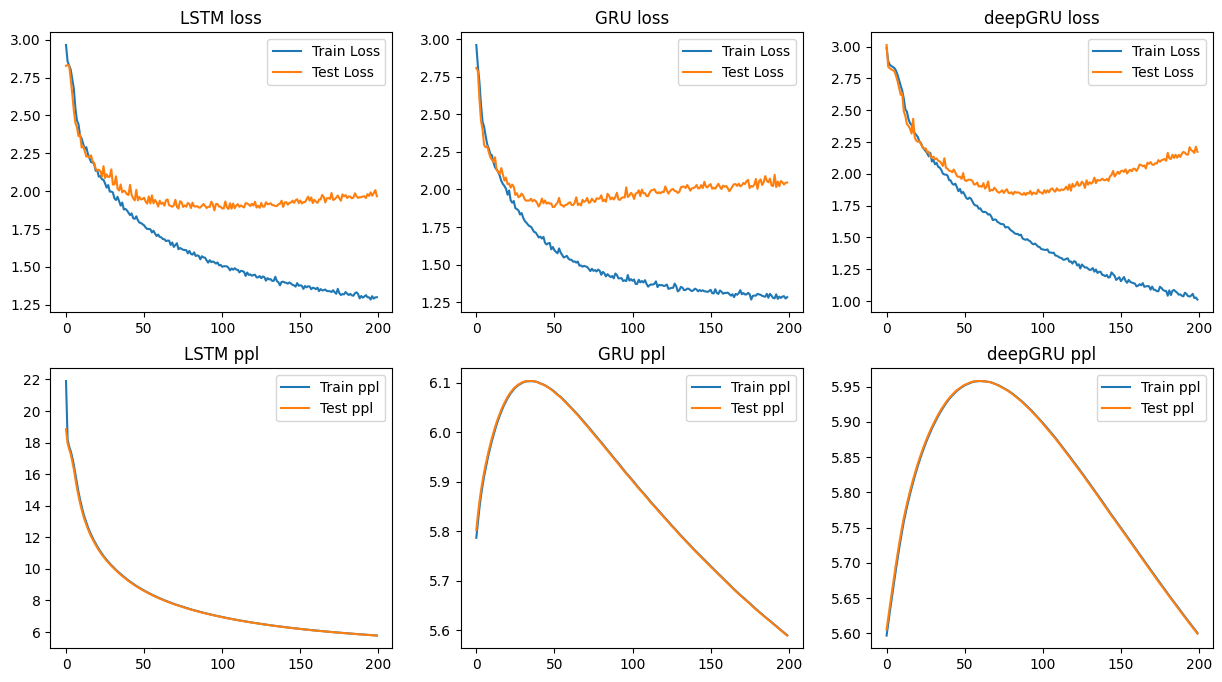

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

for i, (name, d) in enumerate(models.items()):
    plt.subplot(2, 3, i+1)
    plt.title(f"{name} loss")
    plt.plot(d['train_losses'], label='Train Loss')
    plt.plot(d['test_losses'], label='Test Loss')
    plt.legend()

    plt.subplot(2, 3, i+4)
    plt.title(f"{name} ppl")
    plt.plot(d['train_ppls'], label='Train ppl')
    plt.plot(d['test_ppls'], label='Test ppl')
    plt.legend()

plt.show()

In [19]:
for name, d in models.items():
    print(d['model'].predict("i am", 30, train_data.vocab))

i am real the time traveller you t
i am barmits a coul but spast the 
i amas that is all recond the time
